In [1]:
import numpy as np 
from itertools import combinations
from collections import defaultdict
from IPython.display import Image

## Construction of Quantum annealing architecture with all-to-all connectivity 

In this notebook, I constructed the architecture of the LHZ with fully connected constraints  

The construction of the LHZ begins with $N$ logical qubits, which in turn generate $K$ physical qubits. The number of the physical qubits is given by  
$$K = {N \choose 2} = N(N-1)/2$$

In this architecture, there will be $K-N+1$ plaquettes of constraint.  

Schematic of the LHZ architecture is shown below. 


In [2]:
class FullyConnectedLHZ:
    def __init__(self, N, logicalQubit):
        self.N = N
        self.K = int(N*(N-1)/2)               # number of physical qubits 
        self.NLoop = self.K-N+1              # number of constraint loops
        self.logicalQubit = logicalQubit     # sequence of logical qubits
        self.idx = np.arange(self.N)         # array of index for logical qubits 
        self.phyQubit = {}                   # array for physical qubits 
        self.level = defaultdict(list)      # array to be storing indices of physical qubits in each row of LHZ 
        self.CLoop = defaultdict(list)      # array to be storing indices of physical qubits in each contraint plaquette 
        self.idxPhyQubit = []
        
        assert N == len(logicalQubit)
        
    def showVariables(self):
        print("\n")
        print("# of logical qubits:", self.N)
        print("# of physical qubits:", self.K)
        print("# of block loops:", self.NLoop)
        print("sequence of logical qubits:", self.logicalQubit)
        print("\n")
        
    def showReadout(self):
        # readout layer
        #print("\n")
        print("Readout", end=": ")
        for vortex in self.level['s=1']:
            print(self.phyQubit[vortex], end=' ')
     
    def DefinePhysicalQubits(self):
                
        for c in combinations(self.idx,2):
            if self.logicalQubit[c[0]] == self.logicalQubit[c[1]]:
                self.phyQubit[str(c[0]+1)+str(c[1]+1)] = 1
            else: 
                self.phyQubit[str(c[0]+1)+str(c[1]+1)] = 0

        
        # define N-2 additional physical qubits to make four-qubit loops at the bottom level  
        for i in range(2,self.N):
            self.phyQubit[str(i)+str(i)] = 1
       
        l_key =[]
        for key, value in self.phyQubit.items():
            l_key.append(key)
    
        assert len(self.phyQubit) == self.K + self.N-2 
        
        
    def showConstraintBlockLoops(self):
        print("\n")
        print("The following lists show physical qubits belonging to each plaquette")
        print("Note that additional N-2 physical qubits are included in triangle loops at the bottom row s=1, \nwhose values are fixed as 1\n")

        print("index of plaquette, index of physical Qubits: corresponding values of physical qubits")
        for key, value in self.CLoop.items():    
            print(key, value, end='  :')
            for p in value:
                print(self.phyQubit[p], end=' ')
            print("")

    def DefineConstrintLoops(self):        
        k = 1
        for lv in range(1,self.N-1):
            for el in self.level['s='+str(lv)][:-1]:       
                temp= int(el)
                key = 'l='+str(k)
                self.CLoop[key].append(el)   
                self.CLoop[key].append(str(temp+1)) 
                self.CLoop[key].append(str(temp+10)) 
                self.CLoop[key].append(str(temp+11))     
                k = k+1

        assert len(self.CLoop) == self.NLoop
        
    
    def ConstructLHZ(self):
        self.DefinePhysicalQubits()
        
        self.idxPhyQubit = list(self.phyQubit.keys())
        
        # arrange the physical qubits in terms of levels of the architecture 
        for k in range(1,self.N):
            for i in range(self.N):
                if i+k < self.N:            
                    vortex = str(self.idx[i]+1)+str(self.idx[i+k]+1)
                    self.level['s='+str(k)].append(vortex)

        keys = list(self.level.keys())

        print("LHZ with index")
        for kk in reversed(keys):
            print(kk, self.level[kk])

        print("")
        print("LHZ with physical qubit values")
        for kk in reversed(keys):   
            print(kk, end=':  ')
            for p in self.level[kk]:
                print(self.phyQubit[p], end=' ')
            print("")
            
            
        self.DefineConstrintLoops()    
        

The Hamiltonian of LHZ with constraint is 

$$ H_p = \sum_{k=1}^{K}J_k\sigma_k^{(k)} + \sum_{l=1}^{K-N+1} C_l$$

, where the constraint is given by a four-body (north, east, west, and south) interaction as follow $$ C_l = -C \sigma_z^{(l,n)}\sigma_z^{(l,e)}\sigma_z^{(l,w)}\sigma_z^{(l,s)}$$





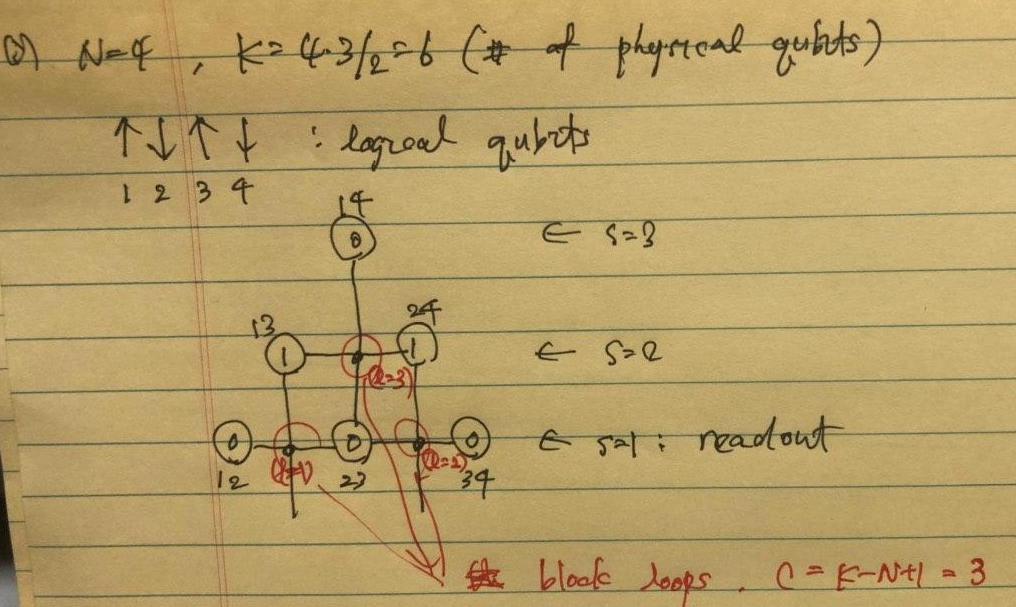

In [3]:
# For N=4, the architecture looks the follow 
display(Image(filename='/Users/gimoonnam/myGit/notRepos/QC/LHZ/N4.jpg', width=600))

In [4]:
N=4
# For logical qubit, -1 for down and 1 for up 
logicalQubit = [1,-1,1,1] 

LHZ_N4 = FullyConnectedLHZ(N,logicalQubit)
LHZ_N4.showVariables()
LHZ_N4.ConstructLHZ()
LHZ_N4.showConstraintBlockLoops()



# of logical qubits: 4
# of physical qubits: 6
# of block loops: 3
sequence of logical qubits: [1, -1, 1, 1]


LHZ with index
s=3 ['14']
s=2 ['13', '24']
s=1 ['12', '23', '34']

LHZ with physical qubit values
s=3:  1 
s=2:  1 0 
s=1:  0 0 1 


The following lists show physical qubits belonging to each plaquette
Note that additional N-2 physical qubits are included in triangle loops at the bottom row s=1, 
whose values are fixed as 1

index of plaquette, index of physical Qubits: corresponding values of physical qubits
l=1 ['12', '13', '22', '23']  :0 1 1 0 
l=2 ['23', '24', '33', '34']  :0 0 1 1 
l=3 ['13', '14', '23', '24']  :1 1 0 0 


In [5]:
LHZ_N4.showReadout()

Readout: 0 0 1 

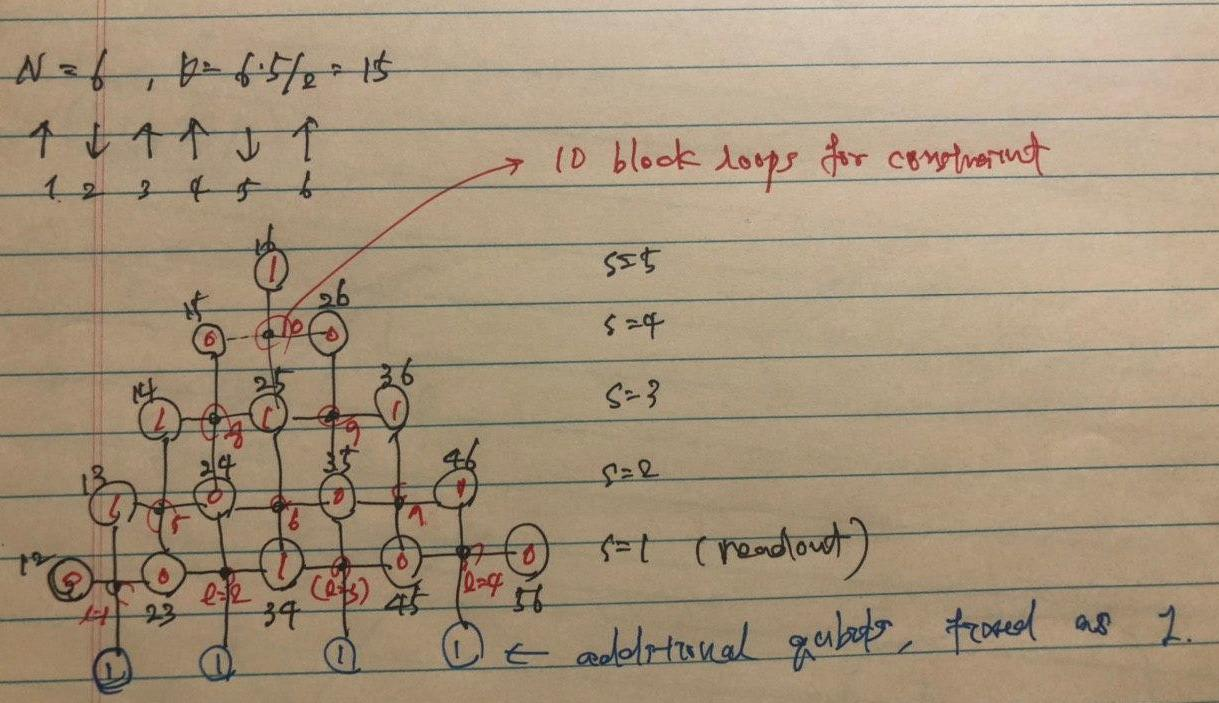

In [6]:
# For N=6 
display(Image(filename='/Users/gimoonnam/myGit/notRepos/QC/LHZ/N6.jpg', width=600))

In [7]:
N = 6
logicalQubit = [1,-1,1,1,-1,1]

LHZ = FullyConnectedLHZ(N,logicalQubit)
LHZ.showVariables()
LHZ.ConstructLHZ()
LHZ.level



# of logical qubits: 6
# of physical qubits: 15
# of block loops: 10
sequence of logical qubits: [1, -1, 1, 1, -1, 1]


LHZ with index
s=5 ['16']
s=4 ['15', '26']
s=3 ['14', '25', '36']
s=2 ['13', '24', '35', '46']
s=1 ['12', '23', '34', '45', '56']

LHZ with physical qubit values
s=5:  1 
s=4:  0 0 
s=3:  1 1 1 
s=2:  1 0 0 1 
s=1:  0 0 1 0 0 


defaultdict(list,
            {'s=1': ['12', '23', '34', '45', '56'],
             's=2': ['13', '24', '35', '46'],
             's=3': ['14', '25', '36'],
             's=4': ['15', '26'],
             's=5': ['16']})

In [8]:
LHZ.showConstraintBlockLoops()



The following lists show physical qubits belonging to each plaquette
Note that additional N-2 physical qubits are included in triangle loops at the bottom row s=1, 
whose values are fixed as 1

index of plaquette, index of physical Qubits: corresponding values of physical qubits
l=1 ['12', '13', '22', '23']  :0 1 1 0 
l=2 ['23', '24', '33', '34']  :0 0 1 1 
l=3 ['34', '35', '44', '45']  :1 0 1 0 
l=4 ['45', '46', '55', '56']  :0 1 1 0 
l=5 ['13', '14', '23', '24']  :1 1 0 0 
l=6 ['24', '25', '34', '35']  :0 1 1 0 
l=7 ['35', '36', '45', '46']  :0 1 0 1 
l=8 ['14', '15', '24', '25']  :1 0 0 1 
l=9 ['25', '26', '35', '36']  :1 0 0 1 
l=10 ['15', '16', '25', '26']  :0 1 1 0 


In [9]:
LHZ.showReadout()

Readout: 0 0 1 0 0 

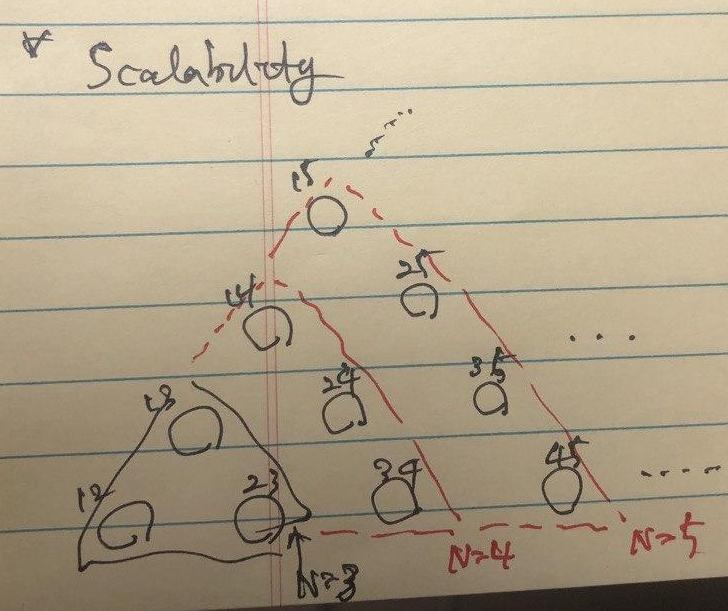

In [10]:
display(Image(filename='/Users/gimoonnam/myGit/notRepos/QC/LHZ/scalability.jpg', width=300))